In [ ]:
import numpy as np
from sklearn.model_selection import ParameterSampler
import json
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
out_dir = '/scratch/snx3000/nchernya/bregression/output_root/'
filename = 'ZHbll_dijetmass_per_event'
data=pd.read_hdf(out_dir+filename+'.hd5',columns=None)

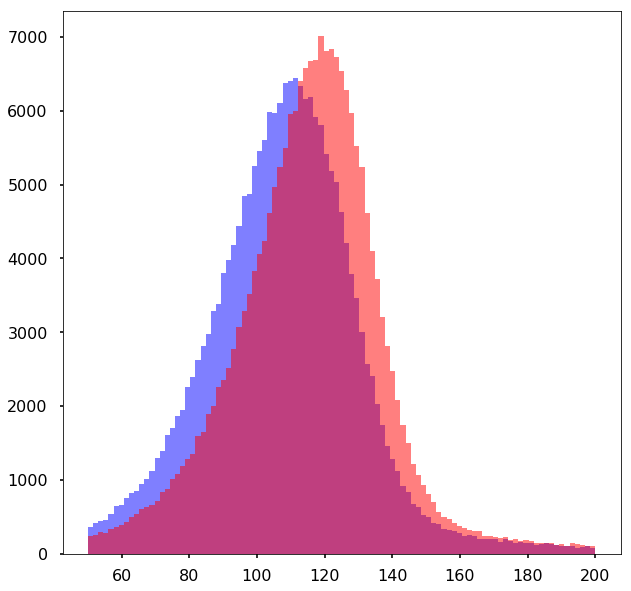

In [3]:
bins = np.linspace(50, 200, 100)
n,bins,patches = plt.hist(data[data.dijetM > 0]['dijetM'],bins=bins,color='blue',alpha=0.5)
n,bins,patches = plt.hist(data[data.dijetM_reg > 0]['dijetM_reg'],bins=bins,color='red',alpha=0.5)

In [4]:
import ROOT
import math
from array import array
from ROOT import std
from ROOT import gROOT
from ROOT import gStyle
from ROOT import TH1F, TGraph, TF1
from ROOT import TCanvas
from ROOT import RooRealVar, RooDataHist, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooBukinPdf, RooBifurGauss, RooGenericPdf, RooChi2Var


Welcome to JupyROOT 6.10/02


In [7]:
def fit_dijetmass(rel_diff_regressed,rel_diff,style=False,n_bins=100,outString=None):
    if style==True:
        gROOT.SetBatch(True)
        gROOT.ProcessLineSync(".x ~/HHbbgg_ETH/scripts/setTDRStyle.C")
        gROOT.ForceStyle()
        gStyle.SetPadTopMargin(0.06)
        gStyle.SetPadRightMargin(0.04)
        gStyle.SetPadLeftMargin(0.15)

    c_min = min(min(rel_diff_regressed),min(rel_diff))
    c_max = max(max(rel_diff_regressed),max(rel_diff))
    c_min=50.
    c_max=200.

    Histo_rel_diff = np.histogram(rel_diff,bins=n_bins,range=(c_min,c_max))
    Histo_rel_diff_reg = np.histogram(rel_diff_regressed,bins=n_bins,range=(c_min,c_max))

    h_rel_diff = TH1F("hrel_diff", "hrel_diff", n_bins, c_min, c_max)
    for i in range(len(rel_diff)):
        h_rel_diff.Fill(rel_diff[i])
    h_rel_diff_reg = TH1F("hrel_diff_reg", "hrel_diff_reg", n_bins, c_min, c_max)
    for i in range(len(rel_diff_regressed)):
        h_rel_diff_reg.Fill(rel_diff_regressed[i])
    h_rel_diff.SetLineColor(ROOT.kBlue)
    h_rel_diff.SetMarkerColor(ROOT.kBlue)
    h_rel_diff.SetLineWidth(2)
    h_rel_diff_reg.SetLineColor(ROOT.kRed)
    h_rel_diff_reg.SetMarkerColor(ROOT.kRed)
    h_rel_diff_reg.SetLineWidth(2)



    AllHistos= [Histo_rel_diff, Histo_rel_diff_reg]
    h_max = max([histo[0].max() for histo in AllHistos])*1.2
    h_min = min([histo[0].min() for histo in AllHistos])

    c = ROOT.TCanvas("c","c",900,900)
    c.cd()
    frame = TH1F("hframe", "hframe", n_bins, c_min, c_max)
    frame.SetStats(0)
    frame.GetXaxis().SetTitleOffset(0.91);
    frame.GetYaxis().SetTitle("Events")
  #  frame.GetXaxis().SetTitle("(p_{T}^{Reco}-p_{T}^{gen})/p_{T}^{gen}")
    frame.GetXaxis().SetTitle("p_{T}^{gen}/p_{T}^{reco}")
    frame.GetYaxis().SetLabelSize(0.04)
    frame.GetYaxis().SetRangeUser(h_min,h_max)

    frame.Draw()
    h_rel_diff.Draw("samePE")
    h_rel_diff_reg.Draw("samePE")
    print('Nominal : mean, RMS :',h_rel_diff.GetMean(), h_rel_diff.GetRMS())
    print('Regresesd : mean, RMS : ',h_rel_diff_reg.GetMean(), h_rel_diff_reg.GetRMS())


    plotFolder='/scratch/snx3000/nchernya/bregression/plots/dijet/'



    leg = ROOT.TLegend(0.55,0.75,0.9,0.9)
    leg.SetFillStyle(-1)
    leg.SetBorderSize(0)
    leg.SetTextFont(42)
    leg.SetTextSize(0.03)
  #  leg.Draw()


    h_names = ['nom','reg']
    datahists = [h_rel_diff,h_rel_diff_reg]
    x=[]
    datahist=[]
    m=[]
    m_initial=[120.0103e+00,9.5381e-01]
    s=[]
    s_initial=[ 13.210,13.967]
    a=[]
    a_initial=[-7.7802e-01,-1.1260e+00]
    n=[]
    n_initial=[ 6.0149e+00,5.5622e+00]

    Ap,Xp,sigp,xi,rho1,rho2 = [],[],[],[],[],[]
    Xp_initial,sigp_initial,xi_initial,rho1_initial,rho2_initial =  120., 20.11,2.2695e-01, 6.4189e-02,  9.0282e-02
    meanr, sigmaL, sigmaR, alphaL, alphaR = [],[],[],[],[]

    fsig=[]
    sig=[]
    model=[]
    res=[]
    integral=[]
    formula=[]
    scale_factors=[]
    scaled_cb=[]
    func=[]
    colors=[ROOT.kBlue,ROOT.kRed]
    chi_squares=[]
    fwhm_bukin=[]
    fwhm=[]
    fwhm.append( -1 *(h_rel_diff.GetBinCenter( h_rel_diff.FindFirstBinAbove(h_rel_diff.GetMaximum()/2.)  )  - h_rel_diff.GetBinCenter( h_rel_diff.FindLastBinAbove(h_rel_diff.GetMaximum()/2.) ) )  )
    fwhm.append( -1 *(h_rel_diff_reg.GetBinCenter( h_rel_diff_reg.FindFirstBinAbove(h_rel_diff_reg.GetMaximum()/2.)  )  - h_rel_diff_reg.GetBinCenter( h_rel_diff_reg.FindLastBinAbove(h_rel_diff_reg.GetMaximum()/2.) ) )  )

    for num,h in enumerate(h_names):
        x.append(RooRealVar("x_%s"%h,"x_%s"%h,c_min,c_max))
        datahist.append(RooDataHist("roohist_%s"%h,"roohist_%s"%h,RooArgList(x[num]),datahists[num]))

      #######################Bukin function ##################

        Xp.append(RooRealVar("Xp_%s"%h,"Xp_%s"%h,Xp_initial,100,140.))
        sigp.append(RooRealVar("sigp_%s"%h,"sigp_%s"%h,sigp_initial,10,40))
        xi.append(RooRealVar("xi_%s"%h,"xi_%s"%h,xi_initial,-1,1))
        rho1.append(RooRealVar("rho1_%s"%h,"rho1_%s"%h,rho1_initial,-1,1)) #left
        rho2.append(RooRealVar("rho2_%s"%h,"rho2_%s"%h,rho2_initial,-1,1)) #right
        sig.append(RooBukinPdf("signal_bukin_%s"%h,"signal_bukin_%s"%h,x[num],Xp[num],sigp[num],xi[num],rho1[num],rho2[num]))
        res.append(sig[num].fitTo(datahist[num],ROOT.RooFit.Save(ROOT.kTRUE)))
        res[num].Print()

       # chi_squares.append((x[num].frame()).chiSquare())
        x[num].setRange("integralRange%s"%h, c_min,c_max)
        integral.append(sig[num].createIntegral(RooArgSet(x[num]), ROOT.RooFit.Range("integralRange%s"%h)))

        scale_factors.append(datahists[num].Integral()*datahists[num].GetBinWidth(1)/integral[num].getVal())
        scale_factors.append(datahists[num].Integral()*datahists[num].GetBinWidth(1)/integral[num].getVal())
      #  formula.append("%f *signal_gauss_%s"%(scale_factors[num],h))
        formula.append("%f *signal_bukin_%s"%(scale_factors[num],h))
     #   formula.append("%f *signal_cruijff_%s"%(scale_factors[num],h))
       # create a scaled  function = scale * function
        scaled_cb.append(RooFormulaVar("scaled_cb_%s"%h,formula[num],RooArgList(sig[num])))
        func.append(scaled_cb[num].asTF(RooArgList(x[num])))
        func[num].SetLineColor(colors[num])
        datahists[num].SetMarkerColor(colors[num])
        fwhm_bukin.append(sigp[num].getVal()*2*math.sqrt(2*math.log(2)))

      #  chi_squares.append(RooChi2Var("chi2_%s"%h,"chi2_%s"%h,sig[num],datahist[num]))


    fitfunc='Bukin'
  #  fitfunc='Bifurgaus'
    fit_result_file = std.ofstream(plotFolder+"/fitResult_%s"%(fitfunc)+str(outString)+'.txt')
    res[0].floatParsFinal().printMultiline(fit_result_file, 1111, True)
    res[1].floatParsFinal().printMultiline(fit_result_file, 1111, True)
    fit_result_file.close()


    leg.AddEntry(h_rel_diff,"Nominal JEC" ,"P")
    leg.AddEntry(h_rel_diff_reg,"Regressed" ,"P")


    c2 = ROOT.TCanvas("c2","c2",900,900)
    c2.cd()
    frame.Draw()
    func[0].Draw("same")
    func[1].Draw("same")
    h_rel_diff.Draw("PEHISTsame")
    h_rel_diff_reg.Draw("PEHISTsame")
    leg.Draw()

    c2.SaveAs(plotFolder+"dijet_%s_"%(fitfunc)+str(outString)+'.png')
    c2.SaveAs(plotFolder+"dijet_%s_"%(fitfunc)+str(outString)+'.pdf')
    c2.Draw()


In [8]:
fit_dijetmass(data[data.dijetM_reg > 0]['dijetM_reg'].values.reshape(-1,1),data[data.dijetM > 0]['dijetM'].values.reshape(-1,1))


Nominal : mean, RMS : 108.1085913397592 22.1744450649272
Regresesd : mean, RMS :  115.2094734609874 21.675654865486422
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(roohist_nom): fit range of variable x_nom expanded to nearest bin boundaries: [50,200] --> [50,200]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(signal_bukin_nom_Int[x_nom]) using numeric integrator RooIntegrator1D to calculate Int(x_nom)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **   19 **SET PRINT           1
 **********
 **********
 **   20 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 Xp_nom       1.20000e+02  4.00000e+00    1.00000e+02  1.40000e+02
     2 rho1_nom     6.41890e-02  2.00000e-01   -1.00000e+00  1.00000e+00
     3 rho2_nom     9.02820e-02  2.00000e-01   -1.00000e+00  1.00000e+00
     4 sigp_nom     2.01100e+01  3.00000e+00    1.00000e+01  4.00000e+01
     5 xi_nom       2.

Warning in <TROOT::Append>: Replacing existing TH1: hrel_diff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hrel_diff_reg (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hframe (Potential memory leak).
Error in <TUnixSystem::FindDynamicLibrary>: ASImage[.so | .dll | .dylib | .sl | .dl | .a] does not exist in /users/musella/my-env/lib:/users/musella/root/lib:/opt/nvidia/cudatoolkit8.0/8.0.61_2.4.3-6.0.4.0_3.1__gb475d12/lib64:/opt/nvidia/cudatoolkit8.0/8.0.61_2.4.3-6.0.4.0_3.1__gb475d12/extras/CUPTI/lib64:/opt/cray/pe/mpt/7.6.0/gni/mpich-gnu/5.1/lib:/opt/cray/pe/perftools/6.5.1/lib64:/opt/cray/rca/2.2.11-6.0.4.0_13.2__g84de67a.ari/lib64:/opt/cray/alps/6.4.1-6.0.4.0_7.2__g86d0f3d.ari/lib64:/opt/cray/xpmem/2.2.2-6.0.4.0_3.1__g43b0535.ari/lib64:/opt/cray/dmapp/7.1.1-6.0.4.0_46.2__gb8abda2.ari/lib64:/opt/cray/pe/pmi/5.0.12/lib64:/opt/cray/ugni/6.0.14-6.0.4.0_14.1__

Error in callback <bound method CaptureDrawnPrimitives._post_execute of <JupyROOT.utils.CaptureDrawnPrimitives object at 0x2b06622d7668>> (for post_execute):


SystemError: void TPad::SaveAs(const char* filename = "", const char* option = "") =>
    problem in C++; program state has been reset